# DEMO 

Example code to compute FFDI from a zarr store of one of RCM simulations

To fix

The code reads the intake catalogues of the SSP370 runs to get a list of models to process.  This is not necessary but it is a convenient way to get a list of all the files to process

Added the code to process all the files in the search 

only works with module load conda/analysis3-23.10 because of problem with units in DF call (out needs?)!!!


#### required packages

In [1]:
import intake
import xarray as xr
from matplotlib import pyplot as plt

import glob
import pathlib
import traceback
from datetime import datetime

from xclim.indices import (
    keetch_byram_drought_index,
    griffiths_drought_factor,
    mcarthur_forest_fire_danger_index
)


#### start a local Dask client

In [2]:
from dask.distributed import Client
import dask

# Set configuration options
dask.config.set({
    'distributed.comm.timeouts.connect': '90s',  # Timeout for connecting to a worker
    'distributed.comm.timeouts.tcp': '90s',  # Timeout for TCP communications
})

from dask.distributed import Client
client = Client()
client

2024-08-22 20:31:14,940 - distributed.preloading - INFO - Creating preload: /g/data/hh5/public/apps/dask-optimiser/schedplugin.py
2024-08-22 20:31:14,943 - distributed.utils - INFO - Reload module schedplugin from .py file
2024-08-22 20:31:14,945 - distributed.preloading - INFO - Import preload module: /g/data/hh5/public/apps/dask-optimiser/schedplugin.py


Modifying workers


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /node/gadi-cpu-clx-0280.gadi.nci.org.au/65162/proxy/8787/status,
Dashboard: /node/gadi-cpu-clx-0280.gadi.nci.org.au/65162/proxy/8787/status,Workers: 48
Total threads: 48,Total memory: 0 B
Status: running,Using processes: True
Comm: tcp://127.0.0.1:41977,Workers: 48
Dashboard: /node/gadi-cpu-clx-0280.gadi.nci.org.au/65162/proxy/8787/status,Total threads: 48
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:42901,Total threads: 1
Dashboard: /node/gadi-cpu-clx-0280.gadi.nci.org.au/65162/proxy/43987/status,Memory: 0 B
Nanny: tcp://127.0.0.1:42443,


#### ignore warnings

In [3]:
import warnings
warnings.filterwarnings('ignore')

## Obtain the desired catalogues of the simulations to processe

In [4]:
catalogue_path='/g/data/ia39/catalogues'
mRuns = sorted(glob.glob(catalogue_path+'/*ssp370*.json'))
mRuns = sorted(glob.glob(catalogue_path+'/*BARRA*.json'))
print(len(mRuns))

1


In [5]:
# test loading all the catalogues of the data
for file in mRuns: 
    print(file)
    cat1=intake.open_esm_datastore(file)

/g/data/ia39/catalogues/AGCD-05i_BOM_ERA5_historical_hres_BARRA-R2_v1_day.json


# Process one ensemble 

In [6]:
# From one catalogue list save variables
mindex=0  # run to process now set a start
mtmp=mRuns[mindex].split('/')
model_name=mtmp[5].split('.')
print(model_name)
tmp=model_name[0].split('_'); ACS_model=tmp[1]

# now match extract RCM_GCM info 
match=tmp[1]+'_'+tmp[2]
print(match)

['AGCD-05i_BOM_ERA5_historical_hres_BARRA-R2_v1_day', 'json']
BOM_ERA5


In [7]:
%%time
# read in the historical catalogue to compute 
# will modified to use the same Zarr collection
if match != "BOM_ERA5": 
    catalogue_path='/g/data/ia39/catalogues'
    mHis = sorted(glob.glob(catalogue_path+'/*'+match+'*hist*.json'))
    print(len(mHis))
    print(mHis[0])
    cat1=intake.open_esm_datastore(mHis[0])
    pr_his = cat1.search(variable={'pr'}).to_dask(cdf_kwargs={'chunks': {'time': 365, 'lat': 691, 'lon': 886}})
    pr_his
# This is usually computed over a specific period
    pr_annual = pr_his.pr.resample(time="Y").sum().\
        sel(time=slice('1985-01-01', '2015-01-01')).mean("time").\
        assign_attrs(
        units="mm a-1", long_name="Annual average rainfall")
    pr_annual.load()
    plt.subplot(2,2,1); pr_annual.plot()


CPU times: user 24 µs, sys: 0 ns, total: 24 µs
Wall time: 59.4 µs


/scratch/xv83/rxm599/AGCD-05i_BOM_ERA5_historical_hres_BARRA-R2_v1_day.zarr
0.3.0


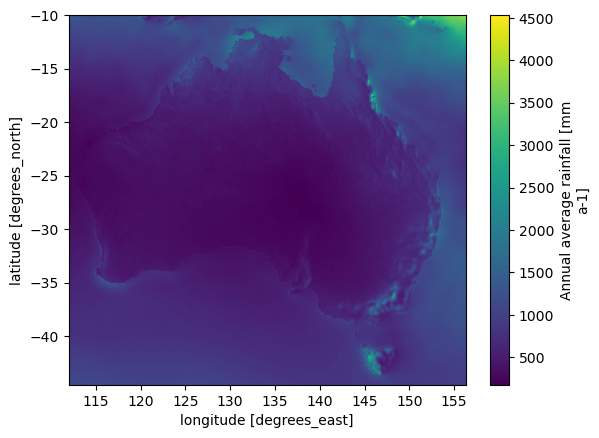

In [8]:
#AGCD-05i_CSIRO_EC-Earth3_ssp370_r1i1p1f1_CCAM-v2203-SN_v1-r1_day.zarr/
dir='/scratch/xv83/rxm599/'
file=dir+model_name[0]+'.zarr'
print(file)
ds0 = xr.open_zarr(file)
ds0

if match == 'BOM_ERA5':  # This is usually computed over a specific period
    pr_annual = ds0.pr.resample(time="Y").sum().\
        sel(time=slice('1985-01-01', '2015-01-01')).mean("time").\
        assign_attrs( units="mm a-1", long_name="Annual average rainfall")

pr_annual.load()
pr_annual.plot()


# Compute FFDI

In [9]:
def calculate_ffdi(pra, tasmaxa, pr_annual, hursmina, sfcWindmaxa):
    KBDI = keetch_byram_drought_index(pra, tasmaxa, pr_annual)
    DF = griffiths_drought_factor(pra, KBDI)
    FFDI = mcarthur_forest_fire_danger_index(DF, tasmaxa, hursmina, sfcWindmaxa)
    return FFDI.to_dataset(name='FFDI')

In [10]:
t1='1975-01-01'; t2='2099-12-31'
pra=ds0.pr.sel(time=slice(t1, t2))
tasmaxa=ds0.tasmax.sel(time=slice(t1,t2))
hursmina=ds0.hursmin.sel(time=slice(t1,t2))
sfcWindmaxa=ds0.sfcWindmax.sel(time=slice(t1,t2))

KBDI = keetch_byram_drought_index(pra, tasmaxa, pr_annual) 
DF = griffiths_drought_factor(pra, KBDI)
FFDI = mcarthur_forest_fire_danger_index(DF, tasmaxa, hursmina, sfcWindmaxa)
ds = FFDI.to_dataset(name='FFDI')

In [16]:
%%time
ds.to_zarr('/g/data/ia39/ncra/fire/'+model_name[0]+'_FFDI.zarr',mode='w')
#tar -czvf compressed_zarr_store.tar.gz /path/to/zarr_store

CPU times: user 1min 14s, sys: 32.2 s, total: 1min 46s
Wall time: 3min 15s


### do not run next cell 

In [ ]:
%%time
# iterate through all models
t1='1975-01-01'; t2='2099-12-31'
for mindex, file in enumerate(mRuns):
    print(file)
# select time period    
    pra=ds0.pr.sel(time=slice(t1, t2))
    tasmaxa=ds0.tasmax.sel(time=slice(t1,t2))
    hursmina=ds0.hursmin.sel(time=slice(t1,t2))
    sfcWindmaxa=ds0.sfcWindmax.sel(time=slice(t1,t2))
    model_name, RCM, GCM, ensemble, pathway = extract_model_info(file)
    dir='/scratch/xv83/rxm599/'
    ifile=dir+model_name[0]+'.zarr'
    print(ifile)
    ds0 = xr.open_zarr(ifile)
    pr_annual=cal_pr_annual(file)
    ds=calculate_ffdi(pra, tasmaxa, pr_annual, hursmina, sfcWindmaxa)

    
print("Processing of all catalogues is complete.")
#client.close()

## Check the output

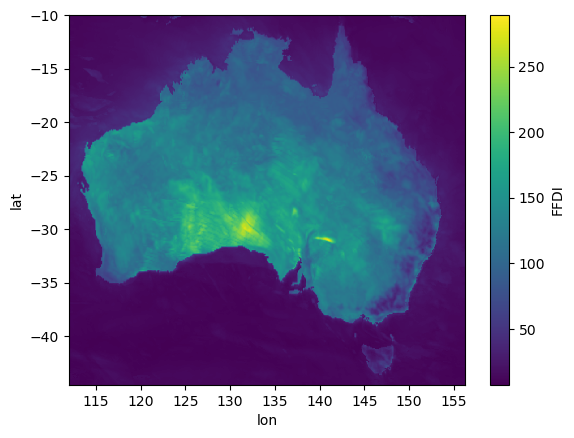

In [11]:
# First 20 points are nan due to the way DI is computed (see XCLIM)
ds1=xr.open_zarr('/g/data/ia39/ncra/fire/'+model_name[0]+'_FFDI.zarr')
ds1.FFDI.isel(time=slice(19,None)).max('time',skipna=False).plot()
#ds1.FFDI.isel(lon=200,lat=300).plot()

In [14]:
print(model_name[0])
data=ds1.FFDI
d3=(data > 100 ).groupby('time.year').sum('time').to_dataset(name='days100')
d2=(data > 75 ).groupby('time.year').sum('time').to_dataset(name='days75')
d1=(data > 50 ).groupby('time.year').sum('time').to_dataset(name='days50')
dss=xr.merge([d1,d2,d3]) 

AGCD-05i_BOM_ERA5_historical_hres_BARRA-R2_v1_day


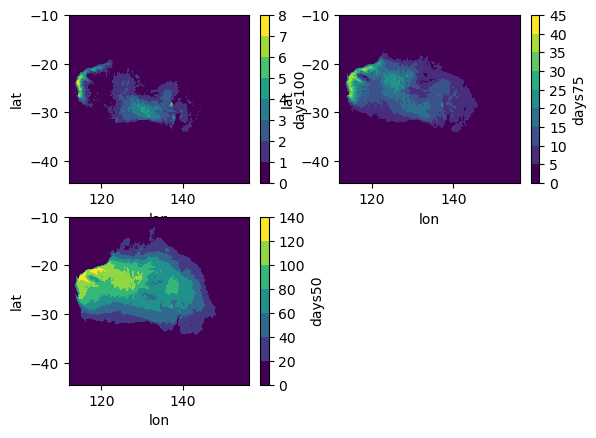

In [17]:
plt.subplot(2,2,1); d3.days100.mean('year').plot(levels=10)
plt.subplot(2,2,2); d2.days75.mean('year').plot(levels=10)
plt.subplot(2,2,3); d1.days50.mean('year').plot(levels=10)

In [24]:
# for BARRA output thresholds to a file
t1=2004; t2=2023
output_path = f'/g/data/ia39/ncra/fire/{model_name[0]}_ffdi_threshold.nc'
dout=dss.sel(year=slice(t1, t2)).mean('year')
dout

dout.to_netcdf(output_path)

In [25]:
client.shutdown()